<a href="https://colab.research.google.com/github/poetictions/MNIST-Neural-Network/blob/main/mnist_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [ ]:
input_size = 28*28
num_classes = 10

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())
batch_size = 128
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
class ModelMNIST(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.l1 = torch.nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.reshape((-1, self.input_size))
        return F.softmax(self.l1(x), dim=1)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['val_loss'], result['val_acc']))


mnist = ModelMNIST(input_size, num_classes)
mnist.parameters

<bound method Module.parameters of ModelMNIST(
  (l1): Linear(in_features=784, out_features=10, bias=True)
)>

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)

In [ ]:
epoch = 15
learning_rate = 0.001
fit(epoch, learning_rate, mnist, train_loader, val_loader)

Epoch [0], val_loss: 1.6393, val_acc: 0.8807
Epoch [1], val_loss: 1.6000, val_acc: 0.8968
Epoch [2], val_loss: 1.5841, val_acc: 0.9028
Epoch [3], val_loss: 1.5753, val_acc: 0.9065
Epoch [4], val_loss: 1.5697, val_acc: 0.9091
Epoch [5], val_loss: 1.5646, val_acc: 0.9126
Epoch [6], val_loss: 1.5615, val_acc: 0.9151
Epoch [7], val_loss: 1.5589, val_acc: 0.9150
Epoch [8], val_loss: 1.5564, val_acc: 0.9178
Epoch [9], val_loss: 1.5542, val_acc: 0.9193
Epoch [10], val_loss: 1.5531, val_acc: 0.9187
Epoch [11], val_loss: 1.5515, val_acc: 0.9199
Epoch [12], val_loss: 1.5503, val_acc: 0.9212
Epoch [13], val_loss: 1.5498, val_acc: 0.9215
Epoch [14], val_loss: 1.5482, val_acc: 0.9226


tensor([3, 3, 8, 7])

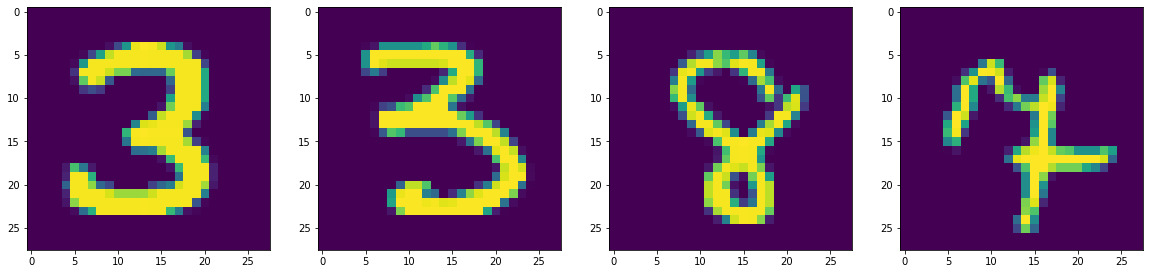

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
check_img = None
with torch.no_grad():
    for images in val_loader:
        preds = torch.argmax(mnist(images[0][:4]), dim=1)
        check_img = images[0][:4]
        break   
for index, image in enumerate(check_img):
    ax[index].imshow(image[0, :, :])
preds